In [8]:
# See if we have GPU access
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
# Optionally set debugging
# tf.debugging.set_log_device_placement(True)
# tf.debugging.set_log_device_placement(False)

In [10]:
# Load the annotation data
from json import load
from pathlib import Path

p = (Path().resolve() / "../pose_data/annotations.json").resolve()
annotations = load(p.open())

In [11]:
# Load annotated images in the following categories
ALLOW_ALL = True
ALLOWED_CATEGORIES = ["bicycling", "running", "walking"]
#ALLOWED_JOINTS = [1, 4, 9, 12, 13] # r knee, l knee, head, r shoulder, l shoulder
ALLOWED_JOINTS= [9]


valid_imgs = []
for i in range(len(annotations["act"])):
    if ALLOW_ALL or annotations["act"][i]["cat_name"] in ALLOWED_CATEGORIES:
        valid_imgs.append(i)
print(f"Indexed {len(valid_imgs)} images with valid categories")

Indexed 24987 images with valid categories


In [12]:
# Parse it to only images with a single person visible
import numpy as np

annorect_imgs = []

#for i in range(len(valid_imgs)):
i = 0
while len(annorect_imgs) < 512:
    i_img = valid_imgs[i]
    annolist = annotations["annolist"][i_img]
    annorects = annolist["annorect"]
    if isinstance(annorects, dict): # Only one annorect (one person)
        if "annopoints" in annorects.keys():
            point = annorects["annopoints"]["point"]
            # Check that every joint we care about is annotated]
            all_present = True
            for j in ALLOWED_JOINTS:
                all_present &= j in [p["id"] for p in point]
            if all_present:
                joints = []
                for j in ALLOWED_JOINTS:
                    joints.append([(p["x"], p["y"]) for p in point if p["id"] == j][0])
                annorect_imgs.append({"id": i_img, "joints": np.array(joints)})
    i += 1

print(f"Indexed {len(annorect_imgs)} images with valid annotations")

Indexed 512 images with valid annotations


In [13]:
# Load the images from disk
import cv2
from skimage.transform import resize
from tqdm.auto import tqdm
HEIGHT = 256
WIDTH = 256

images = []

for i in range(len(annorect_imgs)):
    if i % 100 == 0:
        print('.', end="")
#for i in tqdm(range(len(annorect_imgs))):
    image_name = annotations["annolist"][annorect_imgs[i]["id"]]["image"]["name"]
    real_path = (Path().resolve() / "../pose_data/images/" / image_name).resolve()
    img = cv2.imread(real_path.as_posix())
    if img is not None:
        height, width, depth = img.shape
        images.append(
                {
                    "id": annorect_imgs[i]["id"],
                    "image": resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (HEIGHT, WIDTH)),
                    "joints": [(x / width, y / height) for (x, y) in annorect_imgs[i]["joints"]]
                }
            )
print("Done")


......Done


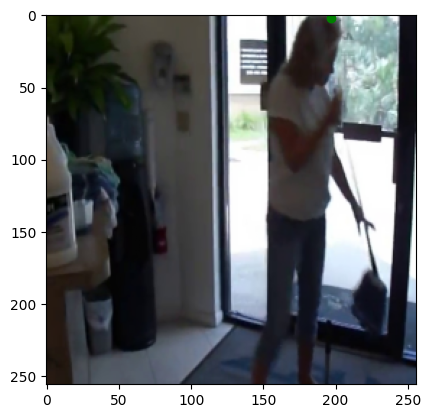

In [14]:
# Show a image from our dataset with the annotations
import matplotlib.pyplot as plt

def show_image(img, points, prediction = None):
    fig, ax = plt.subplots()
    ax.imshow(img)

    height, width, depth = img.shape

    x = [i[0] * width for i in points]
    y = [i[1] * height for i in points]
    plt.plot(x, y, "go")
    if prediction is not None:
        x_pred = [i[0] * width for i in prediction]
        y_pred = [i[1] * height for i in prediction]
        plt.plot(x_pred, y_pred, "ro")
    plt.show()
    
idx = np.random.randint(0, len(images))
show_image(images[idx]["image"], images[idx]["joints"])

In [21]:
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from keras import layers

vgg = VGG19(weights="imagenet", include_top=False, input_tensor=layers.Input(shape=(HEIGHT, WIDTH, 3)))
vgg.trainable = False
flatten = vgg.output
flatten = layers.Flatten()(flatten)

head = layers.Dense(128, activation="relu")(flatten)
head = layers.Dense(64, activation="relu")(head)
head = layers.Dense(32, activation="relu")(head)
head = layers.Dense(2, activation="sigmoid")(head)

model = keras.Model(inputs=vgg.input, outputs=head)

model.summary()

2022-12-12 14:57:57.933317: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.00MiB (rounded to 9437184)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-12-12 14:57:57.933339: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2022-12-12 14:57:57.933347: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 51, Chunks in use: 51. 12.8KiB allocated for chunks. 12.8KiB in use in bin. 2.4KiB client-requested in use in bin.
2022-12-12 14:57:57.933352: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 6, Chunks in use: 6. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2022-12-12 14:57:57.933357: I tensorflow/tsl/

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[3,3,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [16]:
# Split the test data into train/test splits

x = [i["image"] for i in images]
y = [i["joints"] for i in images]

TRAIN_SIZE = 0.75

# TODO: Randomize selection
idx = int(np.floor(TRAIN_SIZE * len(x)))
y_train = np.array(y[:idx])
y_test = np.array(y[idx:])
X_train = np.array(x[:idx])
X_test = np.array(x[idx:])
print("Done")

Done


In [17]:
print(X_train.shape)
print(y_train.shape)

(384, 256, 256, 3)
(384, 1, 2)


In [18]:
# Train the model
model.compile(optimizer="adam", loss=keras.losses.MeanSquaredError(), metrics=["acc"])
model.fit(X_train, y_train, batch_size=64, epochs=1, verbose=2)

2022-12-12 14:43:52.487710: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 288.00MiB (rounded to 301989888)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-12-12 14:43:52.487731: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2022-12-12 14:43:52.487738: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 25, Chunks in use: 25. 6.2KiB allocated for chunks. 6.2KiB in use in bin. 792B client-requested in use in bin.
2022-12-12 14:43:52.487743: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-12-12 14:43:52.487748: I tensorflow/tsl/framework/bfc_allocator.c

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

 7f6dce002600 of size 3584 next 9
2022-12-12 14:43:52.487910: I tensorflow/tsl/framework/bfc_allocator.cc:1090] Free  at 7f6dce003400 of size 32768 next 19
2022-12-12 14:43:52.487914: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f6dce00b400 of size 16384 next 18
2022-12-12 14:43:52.487917: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f6dce00f400 of size 256 next 21
2022-12-12 14:43:52.487920: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f6dce00f500 of size 256 next 20
2022-12-12 14:43:52.487924: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f6dce00f600 of size 256 next 22
2022-12-12 14:43:52.487927: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f6dce00f700 of size 256 next 34
2022-12-12 14:43:52.487930: I tensorflow/tsl/framework/bfc_allocator.cc:1090] Free  at 7f6dce00f800 of size 3328 next 23
2022-12-12 14:43:52.487933: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f6dce010500 of size 4096 next 24


In [ ]:
# Test
test_scores = model.evaluate(X_test, y_test)
print(f"Test loss: {test_scores[0]}")
print(f"Test accuracy: {test_scores[1]}")

In [ ]:
# Visualize a test point
idx = np.random.randint(0, len(X_test))
img = X_test[idx]
prediction = model(np.expand_dims(img, axis=0))
print(y_test[idx])
print(prediction)
show_image(img, y_test[idx], prediction)